In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

In [ ]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
set_all_seeds(RANDOM_SEED)


In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


In [ ]:
class VGG16(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=3,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=64,
                                out_channels=64,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=128,
                                out_channels=128,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_3_skip = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128,
                            out_channels=256,
                            kernel_size=(1, 1),
                            stride=(1, 1),
                            padding=0),
        )

        self.block_3 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=128,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=256,
                                out_channels=256,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                # torch.nn.ReLU(),
                # torch.nn.MaxPool2d(kernel_size=(2, 2),
                #                    stride=(2, 2))
        )


        self.block_4 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=256,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        self.block_5 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.Conv2d(in_channels=512,
                                out_channels=512,
                                kernel_size=(3, 3),
                                stride=(1, 1),
                                padding=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=(2, 2),
                                   stride=(2, 2))
        )

        height, width = 3, 3 ## you may want to change that depending on the input image size
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(512*height*width, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(True),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(4096, num_classes),
        )

        for m in self.modules():
            if isinstance(m, torch.torch.nn.Conv2d) or isinstance(m, torch.torch.nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()

        self.avgpool = torch.nn.AdaptiveAvgPool2d((height, width))


    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        shortcut = self.block_3_skip(x)
        # shortcut = x
        x = self.block_3(x)
        x = torch.nn.functional.relu(x + shortcut)
        # x = torch.nn.functional.max_pool2d(x, kernel_size=(2, 2), stride=(2, 2))
        x = self.block_4(x)
        x = self.block_5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) # flatten

        logits = self.classifier(x)
        #probas = F.softmax(logits, dim=1)

        return logits

In [ ]:
model = VGG16(num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

Epoch: 001/015 | Batch 0000/0175 | Loss: 4.9724
Epoch: 001/015 | Batch 0100/0175 | Loss: 2.1768
Epoch: 001/015 | Train: 21.40% | Validation: 21.14%
Time elapsed: 2.18 min
Epoch: 002/015 | Batch 0000/0175 | Loss: 1.9926
Epoch: 002/015 | Batch 0100/0175 | Loss: 1.7494
Epoch: 002/015 | Train: 38.56% | Validation: 38.96%
Time elapsed: 4.30 min
Epoch: 003/015 | Batch 0000/0175 | Loss: 1.6649
Epoch: 003/015 | Batch 0100/0175 | Loss: 1.6144
Epoch: 003/015 | Train: 47.31% | Validation: 47.26%
Time elapsed: 6.44 min
Epoch: 004/015 | Batch 0000/0175 | Loss: 1.4463
Epoch: 004/015 | Batch 0100/0175 | Loss: 1.3584
Epoch: 004/015 | Train: 53.67% | Validation: 53.64%
Time elapsed: 8.58 min
Epoch: 005/015 | Batch 0000/0175 | Loss: 1.1732
Epoch: 005/015 | Batch 0100/0175 | Loss: 1.1146
Epoch: 005/015 | Train: 60.62% | Validation: 61.28%
Time elapsed: 10.72 min
Epoch: 006/015 | Batch 0000/0175 | Loss: 1.1434
Epoch: 006/015 | Batch 0100/0175 | Loss: 0.9809
Epoch: 006/015 | Train: 64.79% | Validation: 65.

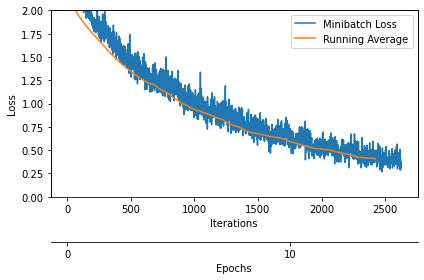

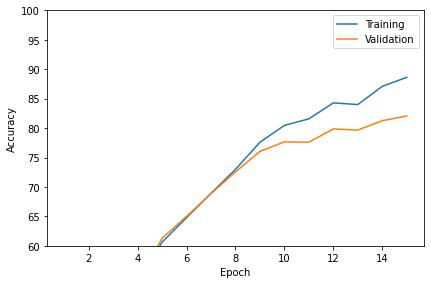

In [ ]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()
























In [ ]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, DEVICE)))

Test accuracy: 81.62%
